# Captions for CLEF16 Data

ImageCLEF captions come from the subfigure segmentation task where one figure (compound or single) comes with a corresponding caption and the bounding boxes for any subfigure. As we want to use the captions for the subfigure classification, which is derived from segmentation dataset, we need to match the captions to the subfigure classification set.

There is one caveat, the subfigure classification task dataset was built using the subfigure bounding boxes but the captions were not processed to match the subfigure. Hence, the same caption will be repeated for the *n* subfigures in a figure. For example:
* Figure '1471-2202-9-58-19.jpg' (nomenclature in segmentation task) has 3 subfigures.
* Subfigures: '1471-2202-9-58-19**-1**.jpg', '1471-2202-9-58-19**-2**.jpg', '1471-2202-9-58-19**-3**.jpg' (nomenclature in subfigure classification task)
* Caption: "This is a sample caption (A) something, (B) something else, (C) another thing" is assigned to the three subfigures.

How will this affect our classification approach? That's yet to be analyzed, but chopping the subfigures is a way to laborious task.

## Our Data
* Captions:
    * CompoundFigureDetectionTraining2016-Captions.csv
    * CompoundFigureDetectionTest2016-Captions.csv
    * We don't have data for ImageClef13 now.
* Images:
    * Organized in folder per modality

## 1. Data Validation

Verify that each image on the CLEF16 training dataset has a corresponding caption.

In [54]:
import pandas as pd
import json
import os
import re
import csv
from pathlib import Path

In [271]:
BASE_PATH = Path('/workspace/data')
IMAGES16_TRAIN = BASE_PATH / 'subfigure-classification' / '2016' / 'train'
IMAGES16_TEST  = BASE_PATH / 'subfigure-classification' / '2016' / 'test'
LABELS16_TEST  = BASE_PATH / 'subfigure-classification' / '2016' / 'test.csv'
# CAPTIONS16_TRAIN = BASE_PATH / 'figure-separation' / '2016' / 'captions-training.csv'
CAPTIONS16_TRAIN = BASE_PATH / 'compound-figure-detection' / '2016' / 'captions-train.csv'
CAPTIONS16_TEST  = BASE_PATH / 'figure-separation' / '2016' / 'captions-test.csv'

DATASET_PATH = BASE_PATH / "multimodality_classification.csv"

I want to create my dataset later with the path to an image, but keeping it relative to wherever I want to place the dataset content. In other words, I don't want to save the **BASE_PATH** in the dataset so I can use it as a parameter. The *pathlib parts* method is handy for this task.

In [117]:
# 3 because of BASE_PATH (start after /data)
Path(*IMAGES16_TRAIN.parts[3:])

PosixPath('subfigure-classification/2016/train')

In [92]:
# os.rename(IMAGES16_TEST / "1471-2105-6-S2-S11-7_1.jpg", IMAGES16_TEST / "IJBI2010-308627.003-1.jpg")
# os.rename(IMAGES16_TEST / "1471-2105-6-S2-S11-7_2.jpg", IMAGES16_TEST / "IJBI2010-308627.003-2.jpg")
# os.rename(IMAGES16_TEST / "1471-2105-6-S2-S11-7_3.jpg", IMAGES16_TEST / "IJBI2010-308627.003-3.jpg")
# os.rename(IMAGES16_TEST / "1471-2105-6-S2-S11-7_4.jpg", IMAGES16_TEST / "IJBI2010-308627.003-4.jpg")
# os.rename(IMAGES16_TEST / "1471-2105-6-S2-S11-7_5.jpg", IMAGES16_TEST / "IJBI2010-308627.003-5.jpg")
# os.rename(IMAGES16_TEST / "1471-2105-6-S2-S11-7_6.jpg", IMAGES16_TEST / "IJBI2010-308627.003-6.jpg")
# os.rename(IMAGES16_TEST / "1471-2105-6-S2-S11-7_7.jpg", IMAGES16_TEST / "IJBI2010-308627.003-7.jpg")
# os.rename(IMAGES16_TEST / "1471-2105-6-S2-S11-7_8.jpg", IMAGES16_TEST / "IJBI2010-308627.003-8.jpg")
# os.rename(IMAGES16_TEST / "1471-2105-6-S2-S11-7_9.jpg", IMAGES16_TEST / "IJBI2010-308627.003-9.jpg")
# os.rename(IMAGES16_TEST / "1471-2105-6-S2-S11-7_10.jpg", IMAGES16_TEST / "IJBI2010-308627.003-10.jpg")

# os.rename(IMAGES16_TEST / "IJBI2010-308627-003-8.jpg", IMAGES16_TEST / "IJBI2010-308627.003-8.jpg")
# os.rename(IMAGES16_TEST / "IJBI2010-535329-1.015.jpg", IMAGES16_TEST / "IJBI2010-535329.015-1.jpg")
# os.rename(IMAGES16_TEST / "IJBI2010-535329-2.015.jpg", IMAGES16_TEST / "IJBI2010-535329.015-2.jpg")
# os.rename(IMAGES16_TEST / "IJBI2010-535329-3.015.jpg", IMAGES16_TEST / "IJBI2010-535329.015-3.jpg")
# os.rename(IMAGES16_TEST / "IJBI2010-535329-4.015.jpg", IMAGES16_TEST / "IJBI2010-535329.015-4.jpg")
# os.rename(IMAGES16_TEST / "IJBI2010-535329-5.015.jpg", IMAGES16_TEST / "IJBI2010-535329.015-5.jpg")

Obtain the list of image names (**training_ids**) from the CLEF16 image folder

In [133]:
def load_test_modalities16():
    with open(LABELS16_TEST) as csvfile:
        reader = csv.reader(csvfile, delimiter=' ')
        return { '{0}.jpg'.format(x[0]): x[1] for x in reader }

def get_modality(dictionary, key):
    try:
        return dictionary[key]
    except:
        return "NONE"
    
modalities16_test = load_test_modalities16()

In [136]:
# modalities in ImageCLEF13 also considered the class COMP, if we use it, make sure to discard it first
modalities = [x.name for x in IMAGES16_TRAIN.glob('*/')]
train_data_16 = [(img_path.name, modality, Path(*img_path.parts[3:])) for modality in modalities 
                 for img_path in (IMAGES16_TRAIN / modality).glob('*.jpg')]  
# to match with captions
train_ids_16 = [x[0] for x in train_data_16] 

test_data_16 = [(img_path.name, get_modality(modalities16_test, img_path.name), 
                 Path(*img_path.parts[3:]))
                for img_path in IMAGES16_TEST.glob('*.jpg')]
test_ids_16  = [x[0] for x in test_data_16]
test_ids_16[:5]

['12178_2008_9035_Fig6_HTML-1.jpg',
 '12178_2008_9035_Fig6_HTML-2.jpg',
 '1297-9686-41-35-3-1.jpg',
 '1297-9686-41-35-3-2.jpg',
 '1423-0127-16-19-5-1.jpg']

In [121]:
train_data_16[:1]

[('1423-0127-16-109-3-1.jpg',
  'D3DR',
  PosixPath('subfigure-classification/2016/train/D3DR/1423-0127-16-109-3-1.jpg'))]

In [231]:
test_data_16[:1]

[('12178_2008_9035_Fig6_HTML-1.jpg',
  'DRXR',
  PosixPath('subfigure-classification/2016/test/12178_2008_9035_Fig6_HTML-1.jpg'))]

As the main difference in the file namings between datasets is the suffix used in the subfigure classification images, the following functions will become handy to match the image with the captions.

In [64]:
# def match_compound(img_id):
#     p = re.compile('(-|[.])[0-9]*-[0-9]*.(jpg)$')
#     match = p.search(img_id)
#     return True if match != None else False

def get_compound_root(img_id):
    # Obtain the part of the image name without subfigure labeling
    p = re.compile('(-|[.])[0-9]*.(jpg)$')
    match = p.search(img_id)
    m_start, m_end = match.span()
    return img_id[:m_start]

def create_captions_dict(csv_file):
    # create a captions dictionary for a convenient matching
    # works for the FIGURE DETECTION file but this files is incomplete
    captions_dict = {}
    with open(csv_file, encoding='ISO-8859-1') as csvfile:
        reader = csv.reader(csvfile, delimiter='\t')
        for row in reader:
            captions_dict[row[0]] = row[1]
    return captions_dict

def create_caption_dictionary(csv_file):
    # works with the COMPOUND FIGURE DETECTION file
    captions = {}
    with open(csv_file, encoding='ISO-8859-1') as csvfile:
        reader = csv.reader(csvfile, delimiter='\t')
        for row in reader:
            # the original file has some empty lines
            if len(row) != 0:
                # lines using tab separators
                if len(row) == 1:
                    sp = row[0].split('\t')
                    if len(sp) == 2:
                        # remove the ,,,,,,,, sequences
                        captions[sp[0]] = sp[1].replace(',,', '').replace("\xa0", "")
                    else:
                        # there is at least one case there the id is not present
                        # so the line has only one value
                        captions[sp[0]] = ''
                elif len(row) == 2:
                    captions[row[0]] = row[1]
    return captions
            
# Tests match_compound
test = '1471-2202-9-58-19-6.jpg'
test2= 'IJBI2010-105610.007-1.jpg'
test3= '11373_2007_9226_Fig1_HTML-16.jpg'

print(get_compound_root(test))
print(get_compound_root(test2))
print(get_compound_root(test3))

1471-2202-9-58-19
IJBI2010-105610.007
11373_2007_9226_Fig1_HTML


In [67]:
captions16_train = create_caption_dictionary(CAPTIONS16_TRAIN)
captions16_test  = create_caption_dictionary(CAPTIONS16_TEST)

print("There are {num} training subfigures.".format(num=len(image_ids_16)))
print("The captions dictionary has {num} captions".format(num=len(captions16_train.keys())))

There are 6776 training subfigures.
The captions dictionary has 20987 captions


### Check Training Data

In [149]:
def check_captions(ids, captions_dict):
    num_has_caption = 0
    imgs_no_caption = []
    
    for img_id in ids:
        try:
            caption = captions_dict[get_compound_root(img_id)]
            num_has_caption += 1
        except KeyError:
            imgs_no_caption.append(img_id)
    
    print("{num} subfigures have a corresponding caption".format(num=num_has_caption))
    print("Only {images} have no captions".format(images=(' ').join(imgs_no_caption)))
    return

check_captions(image_ids_16, captions16_train)

6776 subfigures have a corresponding caption
Only  have no captions


After searching for the key in the dictionary, we can see that the problem is the use of **.001** instead of **-001**. We proceed to create a corresponding key.

In [70]:
found = []
for k in captions16_train.keys():
    if 'DRP2011-927852' in k:
        found.append(k)
print(found)

captions16_train['DRP2011-927852-001'] = captions16_train['DRP2011-927852.001']

['DRP2011-927852.001']


In [138]:
check_captions(image_ids_16, captions16_train)

6776 subfigures have a corresponding caption
Only  have no captions


Checking if any subfigure has an empty caption.

In [139]:
count_empty = 0
for img_id in image_ids_16:
    if captions16_train[get_compound_root(img_id)] == '':
        count_empty += 1
        print(img_id)

if count_empty == 0:
    print("There are no subfigure with empty labels")
else:
    print("There are {num} subfigures with empty labels".format(num=count_empty))

There are no subfigure with empty labels


### Check Test Data

In [140]:
check_captions(test_ids_16, captions16_test)

4158 subfigures have a corresponding caption
Only  have no captions


## Create Dataframe

In [232]:
import pandas as pd

def create_dataset(data, captions_dict):
    df = pd.DataFrame(data, columns =['ID', 'MODALITY', 'PATH'])
    df['CAPTION'] = df.apply(lambda x: captions_dict[get_compound_root(x['ID'])],axis=1)
    df['COMPOUND'] = df.apply(lambda x: get_compound_root(x['ID']), axis=1)
    return df

In [233]:
len(test_data_16)

4158

In [234]:
df16_train = create_dataset(train_data_16, captions16_train)
df16_test  = create_dataset(test_data_16, captions16_test)
df_train.head()

,ID,MODALITY,PATH,CAPTION,COMPOUND
0,1423-0127-16-109-3-1.jpg,D3DR,subfigure-classification/2016/train/D3DR/1423-...,A. Three dimensional model of class C protein ...,1423-0127-16-109-3
1,1423-0127-16-109-3-2.jpg,D3DR,subfigure-classification/2016/train/D3DR/1423-...,A. Three dimensional model of class C protein ...,1423-0127-16-109-3
2,1423-0127-17-34-3-1.jpg,D3DR,subfigure-classification/2016/train/D3DR/1423-...,Three domains of AAG A (or C)-chain: (a) domai...,1423-0127-17-34-3
3,1423-0127-17-34-3-2.jpg,D3DR,subfigure-classification/2016/train/D3DR/1423-...,Three domains of AAG A (or C)-chain: (a) domai...,1423-0127-17-34-3
4,1423-0127-17-34-3-3.jpg,D3DR,subfigure-classification/2016/train/D3DR/1423-...,Three domains of AAG A (or C)-chain: (a) domai...,1423-0127-17-34-3


In [235]:
x = df16_train[['ID', 'COMPOUND', 'MODALITY']].groupby(['COMPOUND', 'MODALITY']).agg(['count'])
# x = df16_train[['ID', 'COMPOUND', 'MODALITY']].groupby(['COMPOUND', 'MODALITY']).size()
x.head(20)

ID
                                   count
COMPOUND                  MODALITY      
11373_2007_9226_Fig1_HTML DMFL        19
12178_2007_9007_Fig1_HTML DMTR         1
                          GHDR         3
12178_2008_9027_Fig4_HTML DRXR         3
12178_2009_9056_Fig9_HTML DRUS         2
1297-9686-42-10-3         GFIG         4
1423-0127-16-109-3        D3DR         2
1423-0127-16-6-3          GFIG         1
                          GGEL         1
1423-0127-16-6-5          GFIG         1
                          GGEL         2
1423-0127-16-7-1          DMEL         5
                          GFIG         1
1423-0127-16-88-1         DMEL         1
                          DMFL         2
                          DMLI         1
                          DRMR         1
1423-0127-17-22-2         GFIG         1
                          GGEL         2
                          GTAB         1

In [256]:
df16_microscopy_train = df16_train[df16_train['MODALITY'].isin(['DMFL', 'DMTR', 'DMLI', 'DMEL'])]
df16_microscopy_test  = df16_test[df16_test['MODALITY'].isin(['DMFL', 'DMTR', 'DMLI', 'DMEL'])]

print(df16_microscopy_train.shape, df16_microscopy_test.shape)
df16_microscopy_train.reset_index()
df16_microscopy_train.head()

(2110, 5) (873, 5)


,ID,MODALITY,PATH,CAPTION,COMPOUND
201,1423-0127-16-7-1-1.jpg,DMEL,subfigure-classification/2016/train/DMEL/1423-...,Scanning electron microscope images of the TiO...,1423-0127-16-7-1
202,1423-0127-16-7-1-2.jpg,DMEL,subfigure-classification/2016/train/DMEL/1423-...,Scanning electron microscope images of the TiO...,1423-0127-16-7-1
203,1423-0127-16-7-1-4.jpg,DMEL,subfigure-classification/2016/train/DMEL/1423-...,Scanning electron microscope images of the TiO...,1423-0127-16-7-1
204,1423-0127-16-7-1-5.jpg,DMEL,subfigure-classification/2016/train/DMEL/1423-...,Scanning electron microscope images of the TiO...,1423-0127-16-7-1
205,1423-0127-16-7-1-6.jpg,DMEL,subfigure-classification/2016/train/DMEL/1423-...,Scanning electron microscope images of the TiO...,1423-0127-16-7-1


In [242]:
df16_microscopy_test.head()

,ID,MODALITY,PATH,CAPTION,COMPOUND
14,1423-0127-17-78-9-1.jpg,DMFL,subfigure-classification/2016/test/1423-0127-1...,Confocal image of 5-HT 2A receptors in the hi...,1423-0127-17-78-9
15,1423-0127-17-78-9-2.jpg,DMFL,subfigure-classification/2016/test/1423-0127-1...,Confocal image of 5-HT 2A receptors in the hi...,1423-0127-17-78-9
16,1423-0127-17-78-9-3.jpg,DMFL,subfigure-classification/2016/test/1423-0127-1...,Confocal image of 5-HT 2A receptors in the hi...,1423-0127-17-78-9
17,1423-0127-17-78-9-4.jpg,DMFL,subfigure-classification/2016/test/1423-0127-1...,Confocal image of 5-HT 2A receptors in the hi...,1423-0127-17-78-9
18,1423-0127-17-78-9-5.jpg,DMFL,subfigure-classification/2016/test/1423-0127-1...,Confocal image of 5-HT 2A receptors in the hi...,1423-0127-17-78-9


In [257]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(df16_microscopy_train,
                              test_size=0.2,
                              random_state=43,
                              shuffle=True,
                              stratify=df16_microscopy_train['MODALITY'])

In [262]:
df16_microscopy_train['SET'] = df16_microscopy_train.apply(
    lambda x: 'TRAIN' if x['ID'] in train['ID'].values else 'VAL', axis=1)
df16_microscopy_train.tail(20)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,ID,MODALITY,PATH,CAPTION,COMPOUND,SET
2291,1756-6606-1-12-6-2.jpg,DMTR,subfigure-classification/2016/train/DMTR/1756-...,PKC Î´ mediates dieldrin-induced DNA fragment...,1756-6606-1-12-6,TRAIN
2292,1756-6606-1-12-6-3.jpg,DMTR,subfigure-classification/2016/train/DMTR/1756-...,PKC Î´ mediates dieldrin-induced DNA fragment...,1756-6606-1-12-6,TRAIN
2293,1756-6606-1-12-6-5.jpg,DMTR,subfigure-classification/2016/train/DMTR/1756-...,PKC Î´ mediates dieldrin-induced DNA fragment...,1756-6606-1-12-6,TRAIN
2294,1756-6606-1-12-6-6.jpg,DMTR,subfigure-classification/2016/train/DMTR/1756-...,PKC Î´ mediates dieldrin-induced DNA fragment...,1756-6606-1-12-6,VAL
2295,1756-6606-2-12-2-4.jpg,DMTR,subfigure-classification/2016/train/DMTR/1756-...,Maintenance of rotarod-running skill requires ...,1756-6606-2-12-2,TRAIN
2296,ar1464-7-5.jpg,DMTR,subfigure-classification/2016/train/DMTR/ar146...,Changes in cell morphology induced by the comb...,ar1464-7,VAL
2297,ar1464-7-7.jpg,DMTR,subfigure-classification/2016/train/DMTR/ar146...,Changes in cell morphology induced by the comb...,ar1464-7,TRAIN
2298,ar1491-3-1.jpg,DMTR,subfigure-classification/2016/train/DMTR/ar149...,Representative optical coherence tomography (O...,ar1491-3,TRAIN
2299,ar1491-4-1.jpg,DMTR,subfigure-classification/2016/train/DMTR/ar149...,An optical coherence tomography (OCT) image (...,ar1491-4,TRAIN
2300,ar1491-5-1.jpg,DMTR,subfigure-classification/2016/train/DMTR/ar149...,Optical coherence tomography (OCT) image (a) ...,ar1491-5,TRAIN


In [263]:
df16_microscopy_train.groupby(['SET']).count()

,ID,MODALITY,PATH,CAPTION,COMPOUND
SET,,,,,
TRAIN,1688,1688,1688,1688,1688
VAL,422,422,422,422,422


In [264]:
df16_microscopy_test['SET'] = 'TEST'
df16_microscopy_test.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,ID,MODALITY,PATH,CAPTION,COMPOUND,SET
14,1423-0127-17-78-9-1.jpg,DMFL,subfigure-classification/2016/test/1423-0127-1...,Confocal image of 5-HT 2A receptors in the hi...,1423-0127-17-78-9,TEST
15,1423-0127-17-78-9-2.jpg,DMFL,subfigure-classification/2016/test/1423-0127-1...,Confocal image of 5-HT 2A receptors in the hi...,1423-0127-17-78-9,TEST
16,1423-0127-17-78-9-3.jpg,DMFL,subfigure-classification/2016/test/1423-0127-1...,Confocal image of 5-HT 2A receptors in the hi...,1423-0127-17-78-9,TEST
17,1423-0127-17-78-9-4.jpg,DMFL,subfigure-classification/2016/test/1423-0127-1...,Confocal image of 5-HT 2A receptors in the hi...,1423-0127-17-78-9,TEST
18,1423-0127-17-78-9-5.jpg,DMFL,subfigure-classification/2016/test/1423-0127-1...,Confocal image of 5-HT 2A receptors in the hi...,1423-0127-17-78-9,TEST


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='MODALITY'>

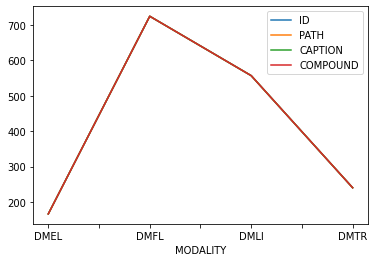

In [265]:
train.groupby(['MODALITY']).count().plot()

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='MODALITY'>

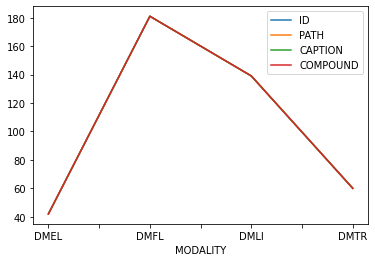

In [266]:
val.groupby(['MODALITY']).count().plot()

In [270]:
df = pd.concat([df16_microscopy_train, df16_microscopy_test])
df.shape

(2983, 6)

In [272]:
df.to_csv(DATASET_PATH, sep='\t')

## Captions with spatial indicators

Captions in compound figures can use the spatial position of the pane as a reference for the related text in the caption. In the example below (left), the top left image is referenced with the text **(A, top left)** but the image itself does not have an **A** label. As the given subfigure (image below, right) does not have any reference to the **A** label and we cannot guess the position in the original compound image, there is no way to relate just a part of the caption to it.

It's worth noticing that for this particular image, the whole caption may indeed be relevant for any pane just because this is an homogeneous case. For instance, **3-D** is mentioned before any specific pane caption and within pane captions. 

*Image on the left taken from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1508147/*

![10.1186/1472-6807-6-9 Figure 6](./samples/PMC1508147.png)